In [16]:
import os
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil



In [17]:
# reproducibility
SEED = 40
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)


In [18]:
# Config
PATCH_SIZE = 128 # or 64 idk
SAFE_MARGIN = 5 # pixels away from tree boxes for negative samples
NEG_RATIO = 1
IMAGES_DIR = "data/TreeBoxes_v0.10/images"
CSV_PATH = "data/TreeBoxes_v0.10/random.csv"


In [19]:
## helper functions

def extract_centered_patch(img, cx, cy, size):
    """extract a square patch centered at (cx,cy) with resize if needed"""
    h, w = img.shape[:2]
    x1 = max(0, cx - size // 2)
    y1 = max(0, cy - size // 2)
    x2 = min(w, cx + size // 2)
    y2 = min(h, cy + size // 2)
    
    patch = img[y1:y2, x1:x2]
    if patch.shape[0] < size or patch.shape[1] < size:
        patch = cv2.resize(patch, (size, size))
    return patch

def is_near_tree(cx, cy, boxes, margin,size):
    """check if point is too close to any tree bounding box"""
    for box in boxes:
        if boxes_overlap(cx,cy,box,size,margin):
            return True
    return False

def boxes_overlap(cx, cy, box, patch_size, margin):
    xmin, ymin, xmax, ymax = box
    # patch
    px1, py1 = cx - patch_size//2 - margin, cy - patch_size//2 - margin
    px2, py2 = cx + patch_size//2 + margin, cy + patch_size//2 + margin
    return not (px2 < xmin or px1 > xmax or py2 < ymin or py1 > ymax)


def save_patch(patch, filepath):
    """save normalized patch as png"""
    cv2.imwrite(str(filepath),cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))



In [20]:


def extract_patches_to_disk(images_dir,output_base):        
    df = pd.read_csv(CSV_PATH)

    output_dir = Path(output_base) / f"patches_v1_seed{SEED}"
    pos_dir = output_dir / "positive"
    neg_dir = output_dir / "negative"

    if os.path.exists(pos_dir):
        shutil.rmtree(pos_dir)
    os.makedirs(pos_dir)

    if os.path.exists(neg_dir):
        shutil.rmtree(neg_dir)
    os.makedirs(neg_dir)
    
    metadata = []
    total_pos_count,total_neg_count = 0,0
    
    for fname in tqdm(df['filename'].unique()):
        pos_count, neg_count = 0,0

        img_path = Path(images_dir) / fname
        img = cv2.imread(str(img_path))

        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        h,w,nchanel = img.shape

        img_boxes = df[df['filename'] == fname][['xmin','ymin','xmax','ymax']].astype(int).values

        #positive, tree centers
        for _,row in df[df['filename'] == fname].iterrows():

            xmin,ymin,xmax,ymax = row[['xmin','ymin','xmax','ymax']].astype(int)
            cx,cy = (xmin+xmax) // 2, (ymin+ymax) // 2

            patch = img[ymin:ymax,xmin:xmax]
            resized_patch = cv2.resize(patch,(PATCH_SIZE,PATCH_SIZE))
            patch_path = pos_dir / f"{total_pos_count}.png"
            save_patch(resized_patch,patch_path)
            
            metadata.append({
                'patch_id':total_pos_count,
                'filename':fname,
                'cx':cx,'cy':cy,
                'label':1,
                'type':'positive'
                })
            pos_count += 1     
            total_pos_count+= 1
           


        #negative, random safe without tree
        n_neg_target = 200 * NEG_RATIO
        attemps = 0

        while neg_count < n_neg_target and attemps < 100000:
            cx = np.random.randint(PATCH_SIZE//2, w - PATCH_SIZE//2) #from left to right
            cy = np.random.randint(PATCH_SIZE//2, h - PATCH_SIZE//2) #from bottom to top
            
            if not is_near_tree(cx,cy,img_boxes,SAFE_MARGIN,PATCH_SIZE):        
                patch = extract_centered_patch(img,cx,cy,PATCH_SIZE)
                patch_path = neg_dir / f'{total_neg_count}.png'
                save_patch(patch,patch_path)
                metadata.append({
                    'patch_id':total_neg_count,
                    'filename':fname,
                    'cx':cx,'cy':cy,
                    'label':0,
                    'type':'negative'
                })
                neg_count += 1
                total_neg_count+= 1
            attemps += 1
            
    
    metadata_df = pd.DataFrame(metadata)
    metadata_path = Path(output_base) / f"patches_v1_seed{SEED}" / "metadata.csv"
    metadata_df.to_csv(metadata_path,index=False)

    print(f"{total_pos_count} positive and {total_neg_count} negative pacthes")
    return metadata_df





In [21]:
output_base = "patches_dataset"

metadata = extract_patches_to_disk(IMAGES_DIR,output_base)


100%|███████████████████████████████████████████| 11/11 [00:35<00:00,  3.22s/it]

5294 positive and 836 negative pacthes


True

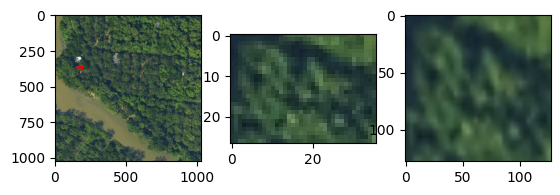

In [22]:
######## testing


df = pd.read_csv(CSV_PATH)
row = df.iloc[500]
img_path = Path(IMAGES_DIR) / row["filename"]
img = cv2.imread(str(img_path))
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
h,w,nchan = img_rgb.shape #1024*1024*3
#print(first[['xmin','ymin','xmax','ymax']].astype(int))
xmin,ymin,xmax,ymax = row[['xmin','ymin','xmax','ymax']].astype(int)
patch = img_rgb[ymin:ymax,xmin:xmax]
#crop.shape 61,69,3
PATCH_SIZE = 128
resized_patch = cv2.resize(patch,(PATCH_SIZE,PATCH_SIZE))
fig,axes = plt.subplots(1,3)

axes[0].imshow(img_rgb)
rect = plt.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,facecolor="none",edgecolor="red")
axes[0].add_patch(rect)

axes[1].imshow(patch)
axes[2].imshow(resized_patch)
output = Path("test_patch")
if os.path.exists(output):
    shutil.rmtree(output)
os.makedirs(output)
cv2.imwrite(str(output / "test.png"),cv2.cvtColor(resized_patch, cv2.COLOR_RGB2BGR))


In [23]:
############ testing

img_boxes = df[df['filename'] == row['filename']][['xmin','ymin','xmax','ymax']].astype(int).values
SAFE_MARGIN = 5
neg_count = 0
attemps = 0
while neg_count < 100 and attemps < 100000:
    cx = np.random.randint(PATCH_SIZE//2, w - PATCH_SIZE//2) #from left to right
    cy = np.random.randint(PATCH_SIZE//2, h - PATCH_SIZE//2) #from bottom to top
    
    if not is_near_tree(cx,cy,img_boxes,SAFE_MARGIN,PATCH_SIZE):        
        patch = extract_centered_patch(img_rgb,cx,cy,PATCH_SIZE)
        save_patch(patch,output/ f"negtest{neg_count}.png")        
        neg_count += 1
    attemps += 1
print(neg_count,attemps)

36 100000
